# Import libraries

In [351]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

np.random.seed(42)
palette = 'rocket'
green = sns.color_palette(palette, n_colors=1)

# Loading dataset

In [352]:
df = pd.read_csv('./Data/bank.csv')
print('Number of datapoints:', len(df))
df.head(3)

Number of datapoints: 11162


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes


In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


**Field information**
- age | int64 | age in years
- job | object | type of job (categorical: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar' 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed' 'student'])
- marital | object | marital status (categorical: ['married' 'single' 'divorced'])
- education | Object | education background (categorical: ['secondary' 'tertiary' 'primary' 'unknown'])
- default | Object | has credit in default? (categorical: ['no' 'yes'])
- balance | int64 | Balance of the individual
- housing | object | has housing loan? (categorical: ['yes' 'no'])
- loan | object | has personal loan? (categorical: ['no' 'yes'])
- contact | object | contact communication type (categorical: ['unknown' 'cellular' 'telephone'])
- day | int64 | last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- month | object | last contact month of year (categorical: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'])
- duration | int64 | last contact duration, in seconds (numeric)
- campaign | int64 | number of contacts performed during this campaign and for this client
- pdays | int64 | number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous | int64 | number of contacts performed before this campaign and for this client
- poutcome | object | outcome of the previous marketing campaign (categorical: ['unknown' 'other' 'failure' 'success'])
- deposit | object | deposit status of client (categorical: ['yes' 'no'])

# Data Cleaning

In [354]:
df = df.dropna()
df = df.drop('contact', axis=1)

**Turning features containing 'yes' and 'no' values to numeric**

In [355]:
numeric_fields = ['default', 'housing', 'loan', 'deposit']

for i in numeric_fields:
    df[i] = np.where(df[i]=='yes',1,0)

**Switch back category fields' dtypes**

In [356]:
category_fields = ['job', 'poutcome', 'education', 'marital']
for i in category_fields:
    df[i] = df[i].astype('category')


# Data Overview

**Plotting category features**

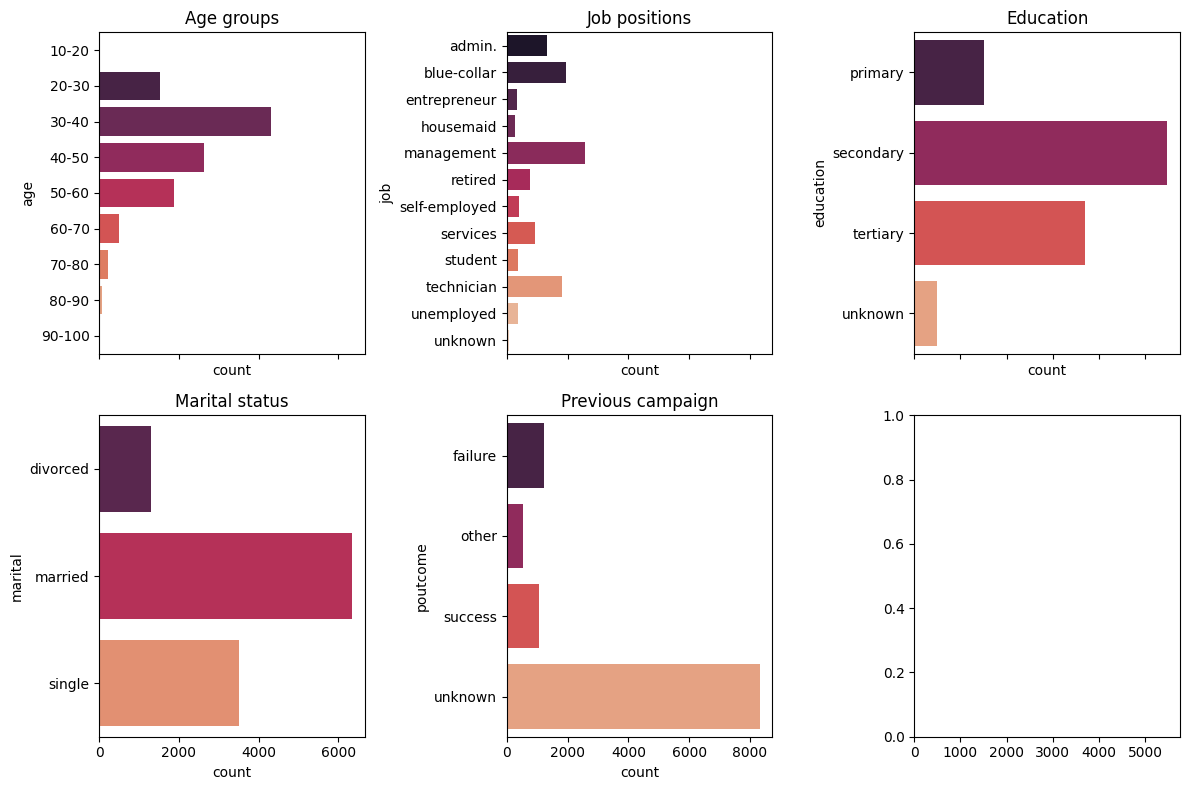

In [357]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex='col')

# Age gaps
age_range_labels = ['10-20', '20-30', '30-40', '40-50',
                    '50-60', '60-70', '70-80', '80-90', '90-100']
age_range = pd.cut(df['age'],
                   bins=[10, 20, 30, 40, 50, 60,
                         70, 80, 90, 100],
                   labels=age_range_labels, right=False)
sns.countplot(ax=axs[0, 0], y=age_range, palette=palette)
axs[0, 0].set_title('Age groups')

# Job positions
sns.countplot(ax=axs[0, 1], y=df['job'], palette=palette)
axs[0, 1].set_title('Job positions')

#  Education
sns.countplot(ax=axs[0, 2], y=df['education'], palette=palette)
axs[0, 2].set_title('Education')

# Marital status
sns.countplot(ax=axs[1, 0], y=df['marital'], palette=palette)
axs[1, 0].set_title('Marital status')

# Outcome of the previous marketing campaign
sns.countplot(ax=axs[1, 1], y=df['poutcome'], palette=palette)
axs[1, 1].set_title('Previous campaign')

plt.tight_layout()
fig.set_size_inches(12, 8)
plt.savefig('./Plot/DataOverview/1-category-features.png')
plt.show()


**Having a look and plotting numeric features**

In [358]:
df.describe()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,0.015051,1528.538524,0.473123,0.130801,15.658036,371.993818,2.508421,51.330407,0.832557,0.473840
std,11.913369,0.121761,3225.413326,0.499299,0.337198,8.420740,347.128386,2.722077,108.758282,2.292007,0.499338
min,18.000000,0.000000,-6847.000000,0.000000,0.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,0.000000,122.000000,0.000000,0.000000,8.000000,138.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,550.000000,0.000000,0.000000,15.000000,255.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,0.000000,1708.000000,1.000000,0.000000,22.000000,496.000000,3.000000,20.750000,1.000000,1.000000
max,95.000000,1.000000,81204.000000,1.000000,1.000000,31.000000,3881.000000,63.000000,854.000000,58.000000,1.000000


<Figure size 640x480 with 0 Axes>

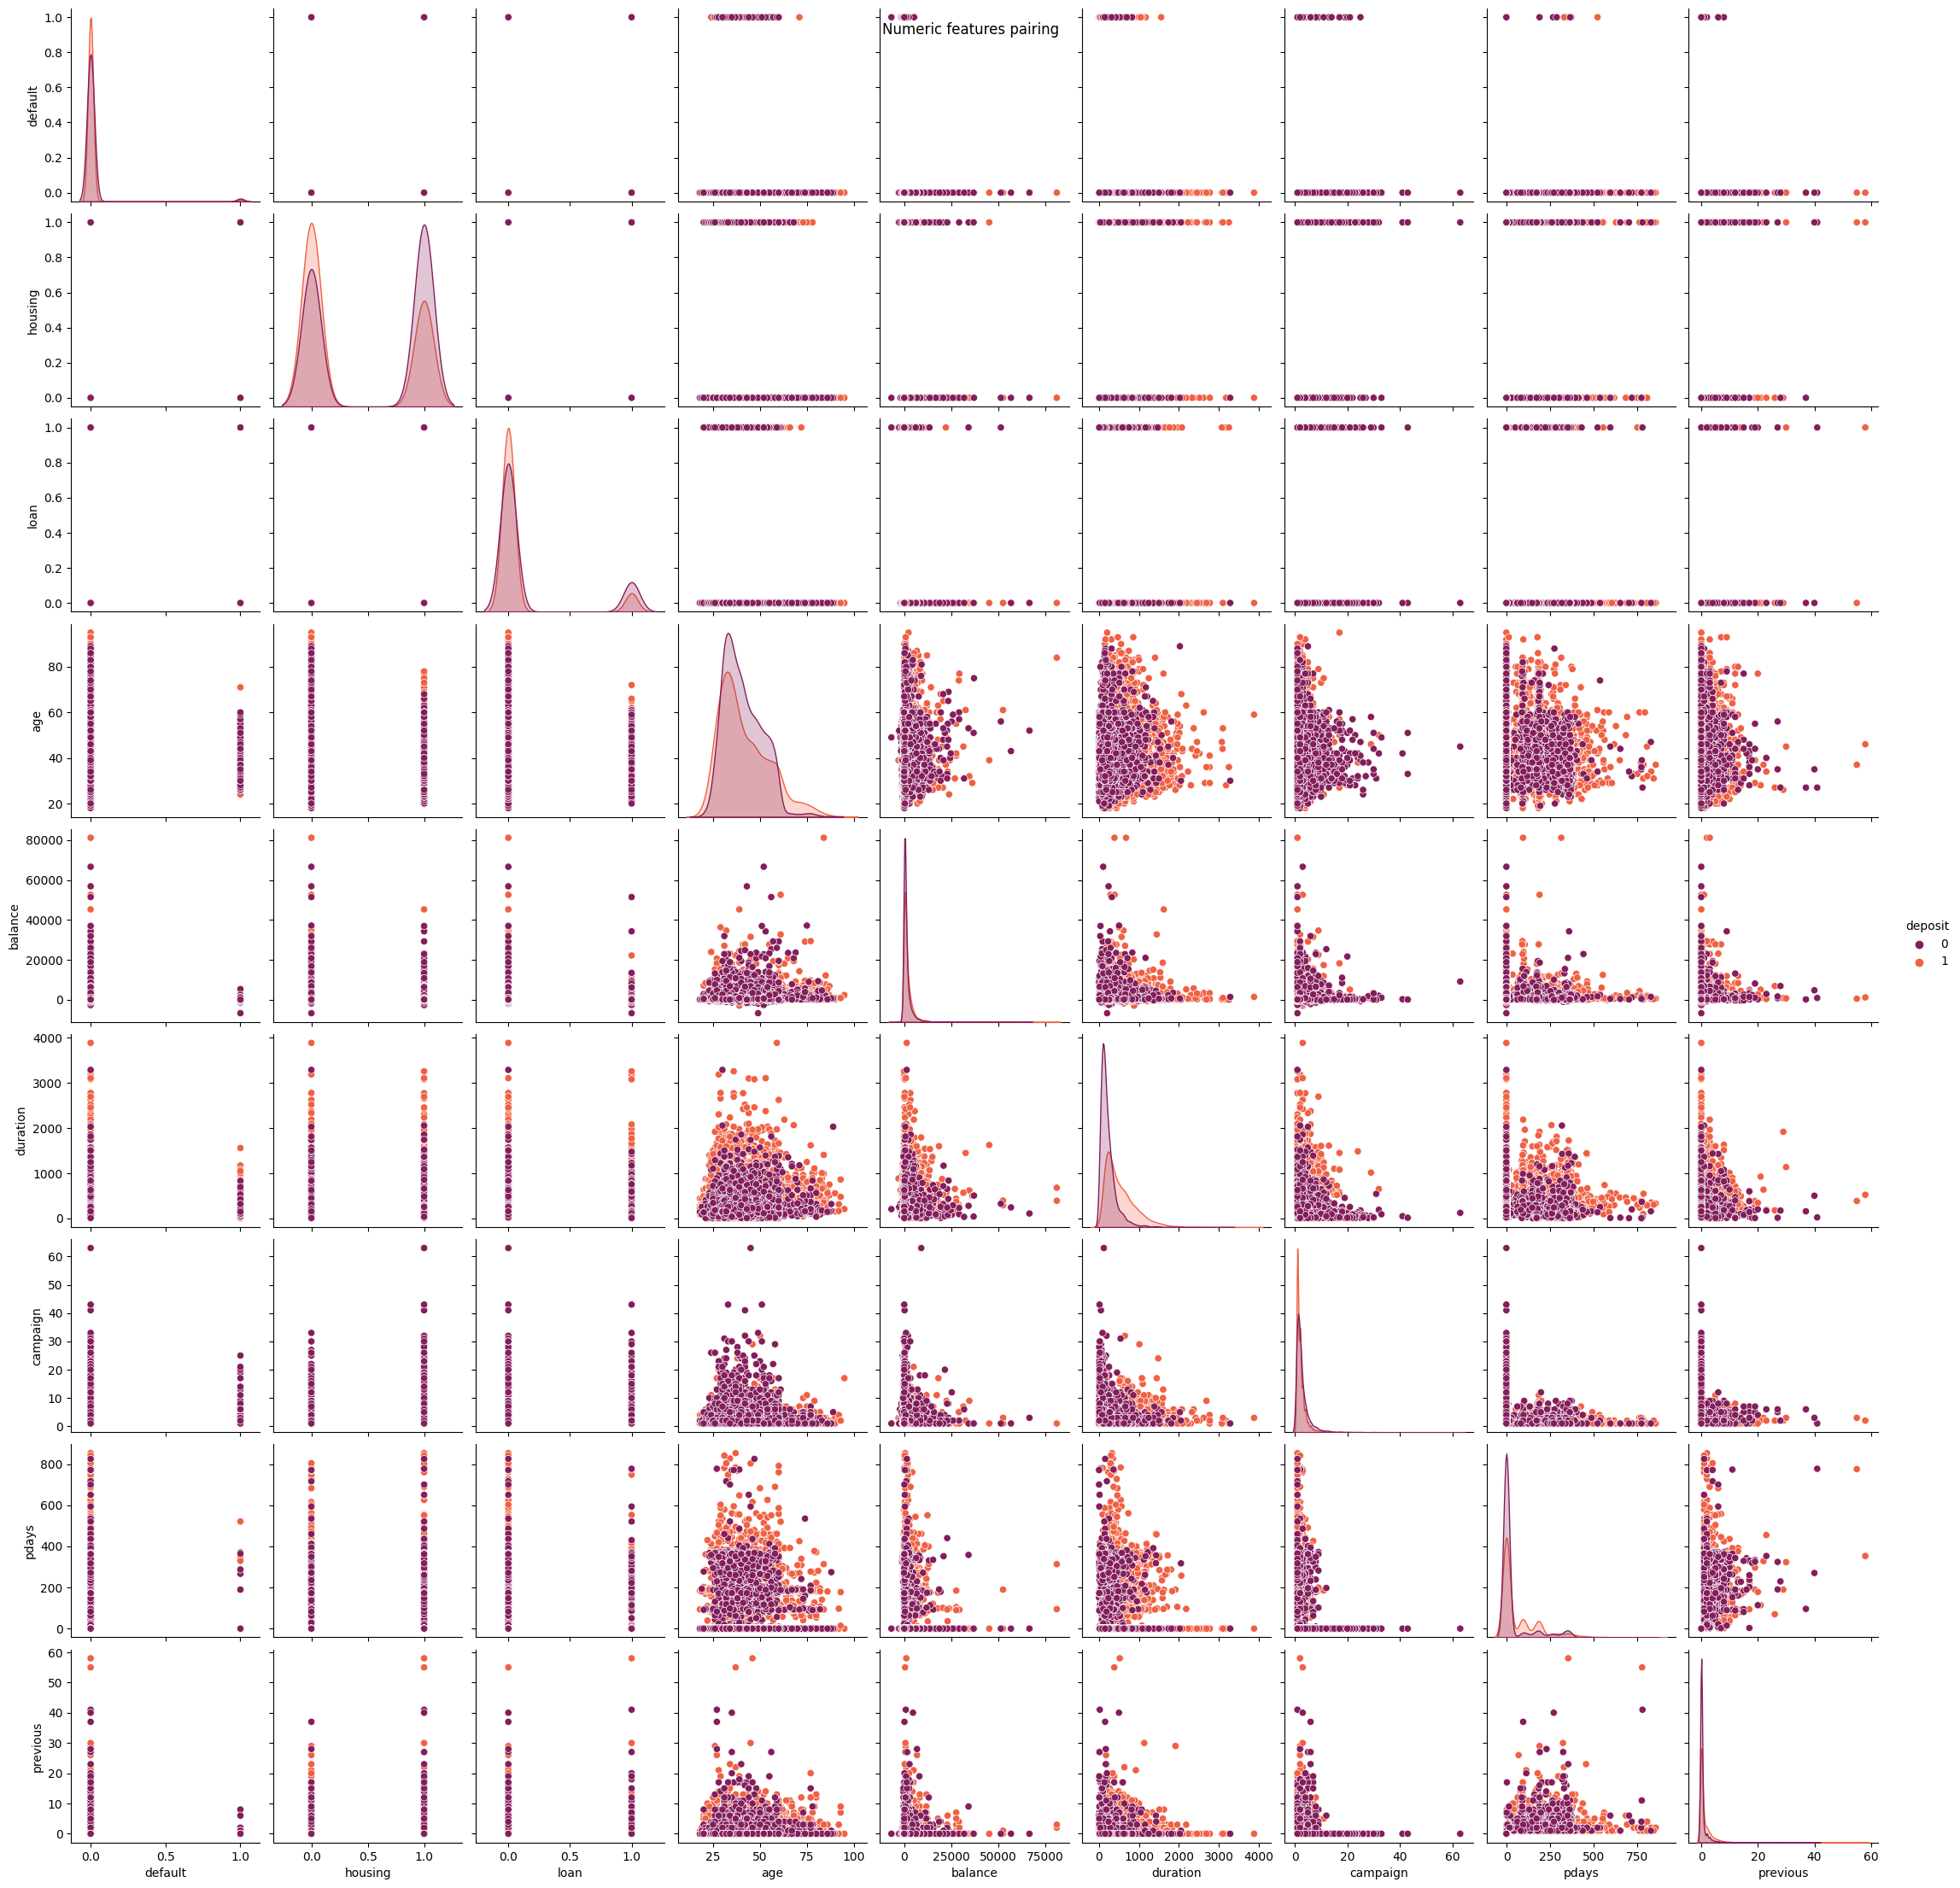

In [359]:
temp = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
for i in temp:
    numeric_fields.append(i)
    
plt.figure()
sns.pairplot(
    df[numeric_fields].drop(['day'], axis=1),
    hue='deposit', 
    palette=palette)
plt.savefig('./Plot/DataOverview/2-numeric-features.png')
plt.suptitle('Numeric features pairing')
plt.show()


# Data Preprocessing

## Preparations

### Encoding data

Turning values into numeric to fit to the model.

In [360]:
encoder = OrdinalEncoder()
encoded_df = pd.DataFrame(encoder.fit_transform(df))
encoded_df.columns = df.columns.tolist()
encoded_df.head(5)

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,41.0,0.0,1.0,1.0,0.0,2288.0,1.0,0.0,4.0,8.0,1021.0,0.0,0.0,0.0,3.0,1.0
1,38.0,0.0,1.0,1.0,0.0,469.0,0.0,0.0,4.0,8.0,1283.0,0.0,0.0,0.0,3.0,1.0
2,23.0,9.0,1.0,1.0,0.0,1618.0,1.0,0.0,4.0,8.0,1246.0,0.0,0.0,0.0,3.0,1.0
3,37.0,7.0,1.0,1.0,0.0,2356.0,1.0,0.0,4.0,8.0,577.0,0.0,0.0,0.0,3.0,1.0
4,36.0,0.0,1.0,2.0,0.0,608.0,0.0,0.0,4.0,8.0,671.0,1.0,0.0,0.0,3.0,1.0


After encoding, we can look at the **correlation** between features.

However, no relationship between two features is strong enough to notice.

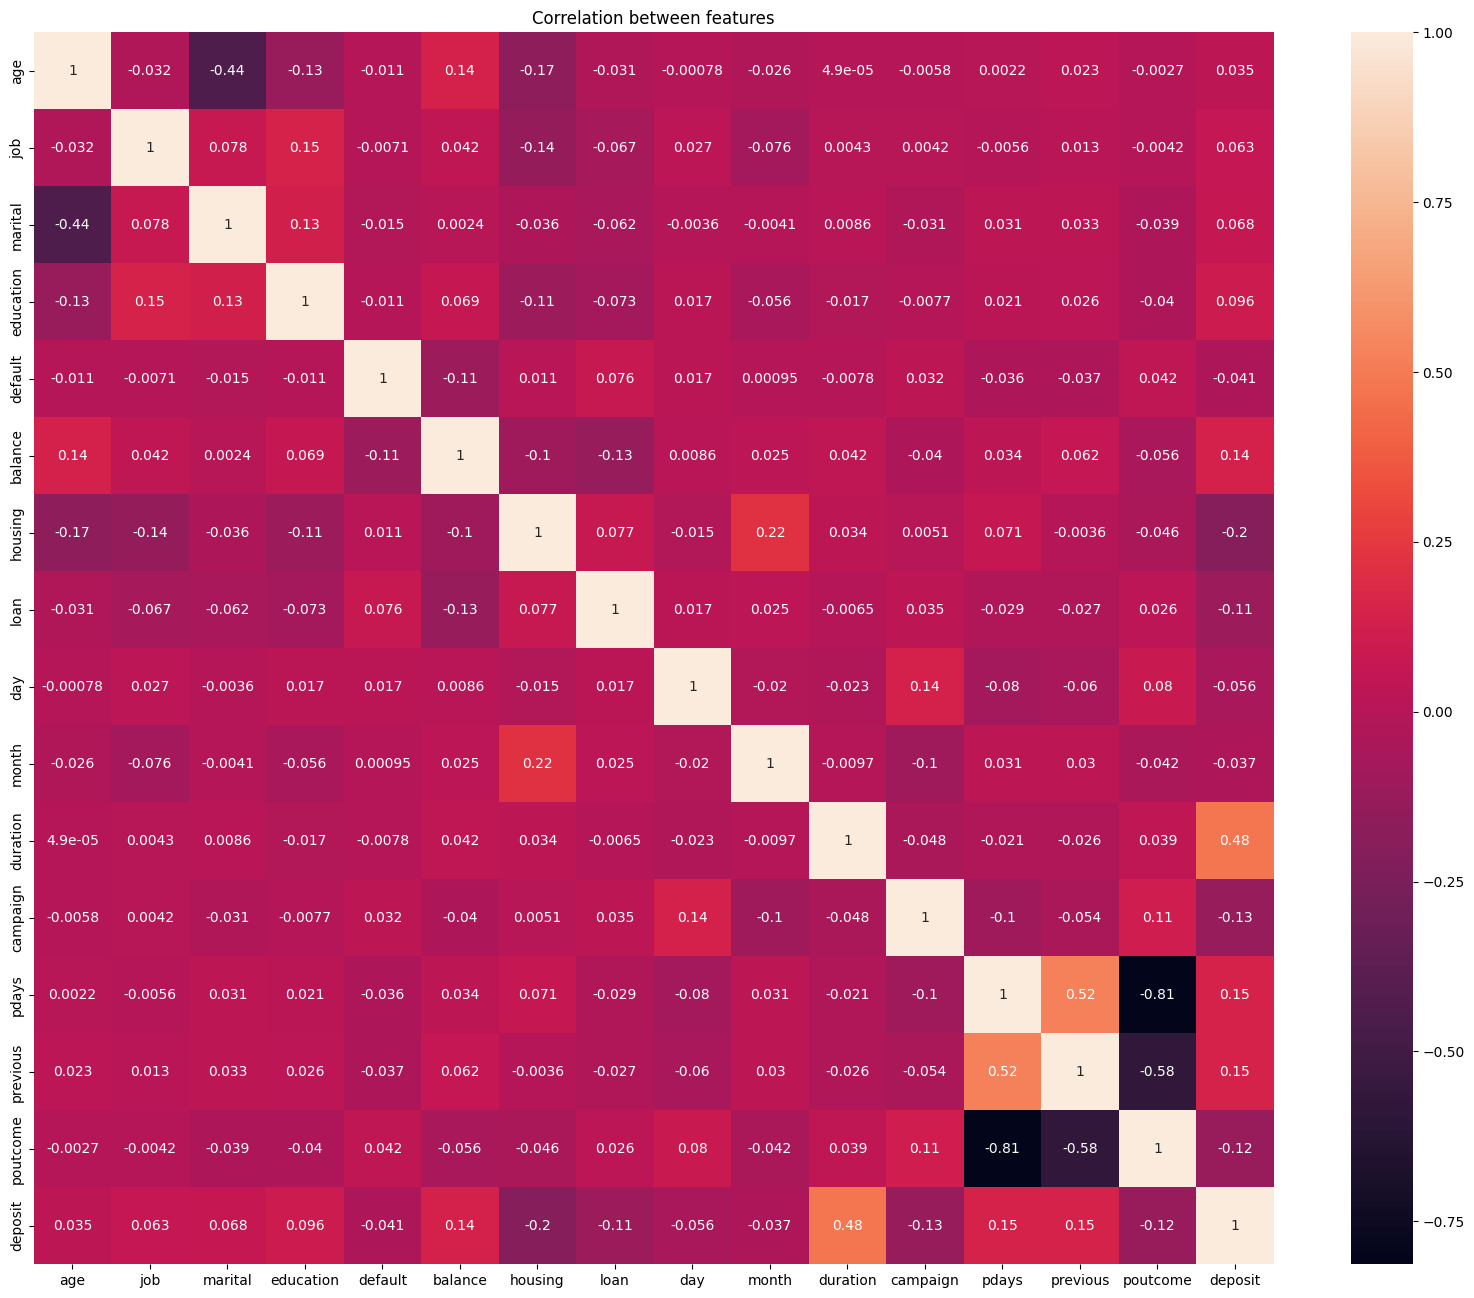

In [361]:
corrmat = encoded_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corrmat, annot=True, cmap=palette)
plt.title('Correlation between features')
plt.savefig('./Plot/DataPreprocessing/3-heatmap.png')
plt.show()


### Standardize data

Transforming the features so that they have zero mean and unit variance, ensuring a common scale and facilitating meaningful comparisons between variables. 

In [362]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(encoded_df) 

### Normalize data

Scaling the features of a dataset to range [-1, 1] in order to maintain the relative relationships between the variables and facilitate comparisons.

In [363]:
normalized_df = normalize(scaled_df) 
normalized_df = pd.DataFrame(normalized_df) 

### Reducing dimensions with PCA (Principal Component Analysis)

Refering a technique that transforms a high-dimensional dataset into a lower-dimensional space by identifying the most important features, called principal components, while preserving as much of the original data's variance as possible.

In [364]:
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 

X_principal.head(5)

,P1,P2
0,0.114762,0.184712
1,0.212000,-0.038809
2,0.239563,0.011254
3,0.142928,0.059478
4,0.189933,-0.119891


## Visualizing datapoints

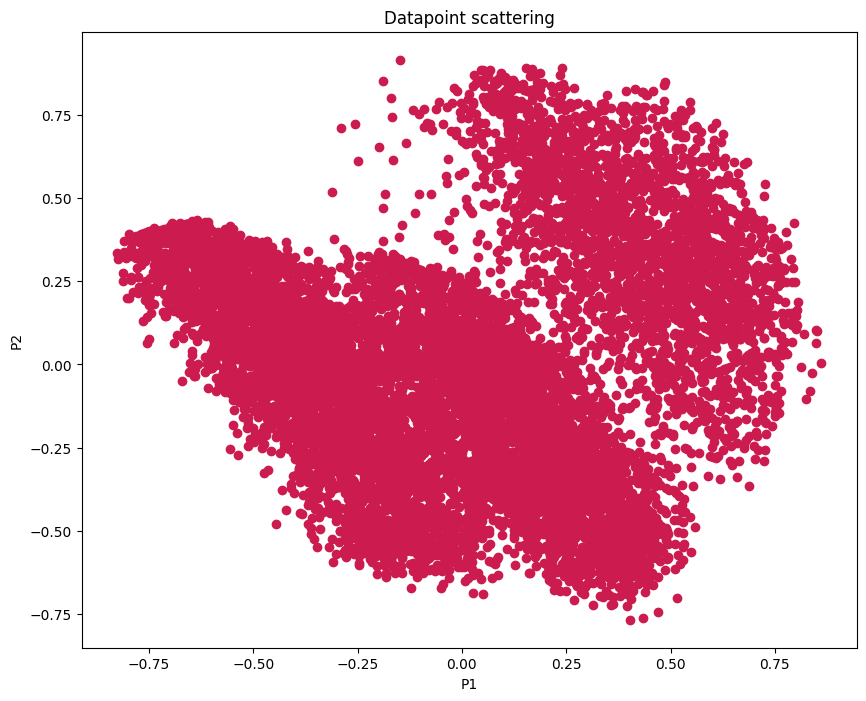

In [365]:
fig = plt.figure(figsize=(10, 8))
ax = fig.subplots()
ax.scatter(X_principal['P1'], X_principal['P2'], color=green)
ax.set_xlabel('P1')
ax.set_ylabel('P2')
# ax.set_zlabel('P3')
plt.title('Datapoint scattering')
plt.savefig('./Plot/DataPreprocessing/4-visualize-datapoints')
plt.show()


# Fitting into GMM

With 4 clusters 

In [366]:
gmm_predictions = GaussianMixture(n_components=4).fit_predict(X_principal)
X_principal['cluster'] = gmm_predictions
df['cluster'] = gmm_predictions

## Visualizing clusters

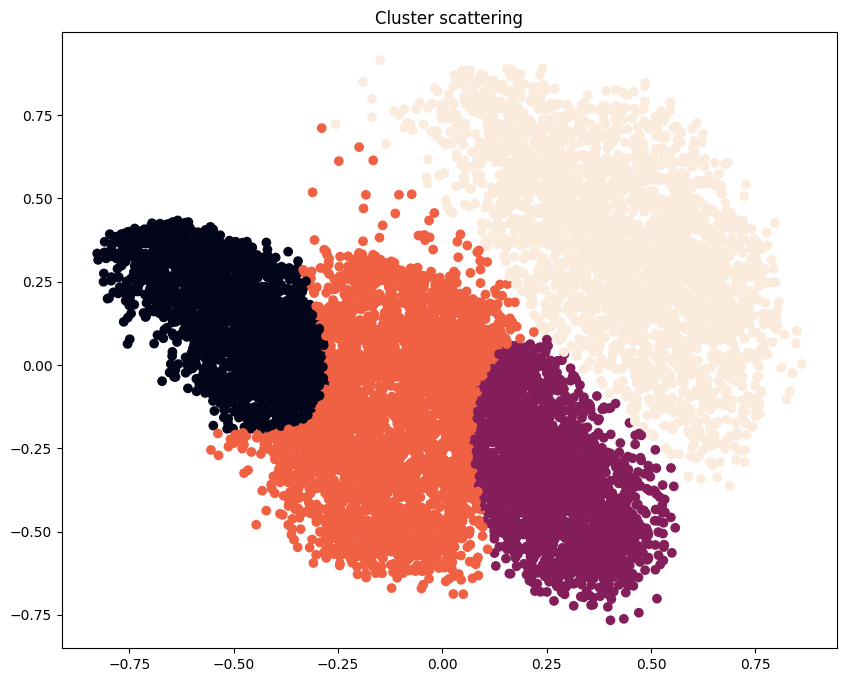

In [367]:
fig = plt.figure(figsize=(10, 8))
ax = fig.subplots()
ax.scatter(X_principal['P1'], X_principal['P2'],
           c=gmm_predictions,
           cmap=palette)
plt.title('Cluster scattering')
plt.savefig('./Plot/DataPreprocessing/5-visualize-clusters')
plt.show()


# Evaluating models

Making evaluations and clearing clusters' qualities

Setting up

In [368]:
yesno_fields = ['default', 'housing', 'loan', 'deposit']

for i in yesno_fields:
    df[i] = np.where(df[i]==1,'yes','no')
    
df['age_group'] = age_range
cluster0 = df[(df['cluster']==0)]
cluster1 = df[(df['cluster']==1)]
cluster2 = df[(df['cluster']==2)]
cluster3 = df[(df['cluster']==3)]

## Distribution

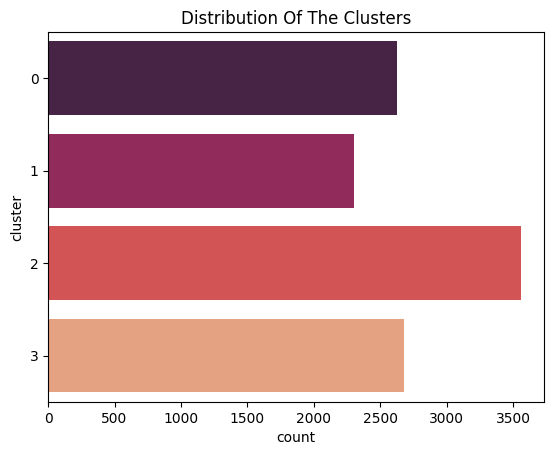

In [369]:
sns.countplot(y=df['cluster'], palette=palette)
plt.title('Distribution Of The Clusters')
plt.savefig('./Plot/Evaluating/6-cluster-distribution.png')
plt.show()

In [370]:
print('Distribution cluster 0:', (len(cluster0) / len(df))*100)
print('Distribution cluster 1:', (len(cluster1) / len(df))*100)
print('Distribution cluster 2:', (len(cluster2) / len(df))*100)
print('Distribution cluster 3:', (len(cluster3) / len(df))*100)


Distribution cluster 0: 23.5262497760258
Distribution cluster 1: 20.60562623185809
Distribution cluster 2: 31.86704891596488
Distribution cluster 3: 24.001075076151228


In [371]:
print(len(cluster0))
print(len(cluster1))
print(len(cluster2))
print(len(cluster3))

2626
2300
3557
2679


## Age groups

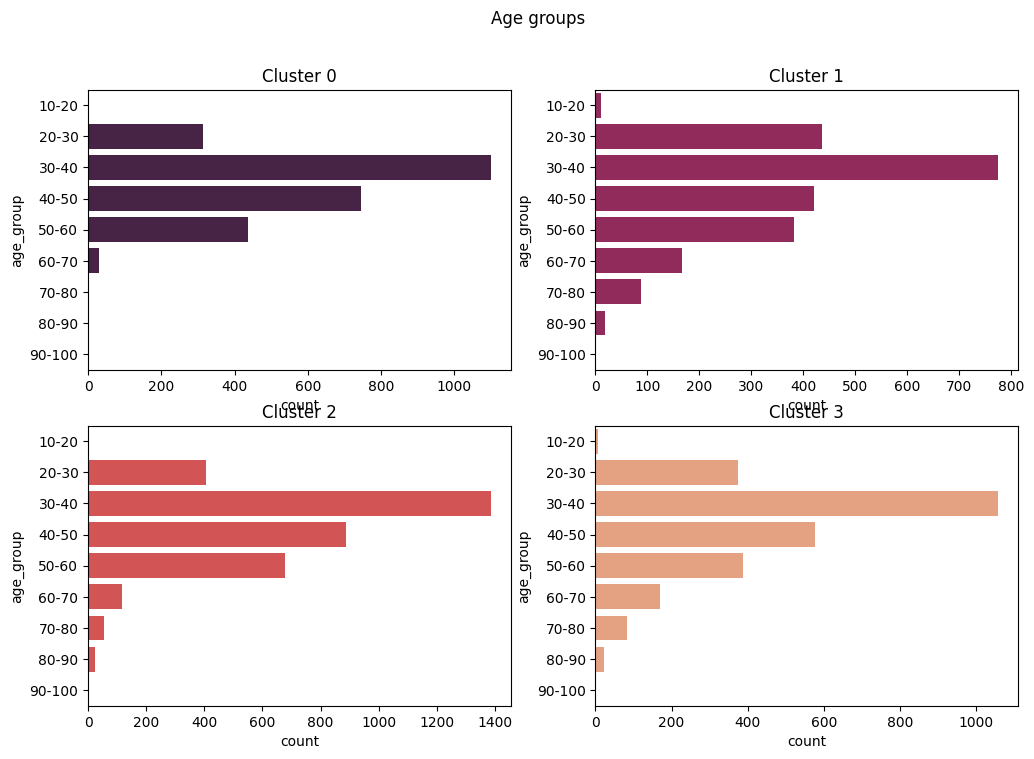

In [372]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
colors = sns.color_palette(palette, n_colors=4)

sns.countplot(ax=axs[0, 0], y=cluster0['age_group'], color=colors[0])
axs[0,0].set_title('Cluster 0')

sns.countplot(ax=axs[0, 1], y=cluster1['age_group'],color=colors[1])
axs[0, 1].set_title('Cluster 1')

sns.countplot(ax=axs[1, 0], y=cluster2['age_group'],color=colors[2])
axs[1, 0].set_title('Cluster 2')

sns.countplot(ax=axs[1, 1], y=cluster3['age_group'],color=colors[3])
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Age groups')
plt.savefig('./Plot/Evaluating/7-agegroups.png')
plt.show()


## Balance

In [373]:
avg_c0  = cluster0['balance'].mean()
avg_c1  = cluster1['balance'].mean()
avg_c2  = cluster2['balance'].mean()
avg_c3  = cluster3['balance'].mean()
print(avg_c0,avg_c1,avg_c2,avg_c3)

701.1454683929932 2199.1591304347826 1480.1239808827663 1828.0970511384844


<Axes: xlabel='cluster', ylabel='avg_balance'>

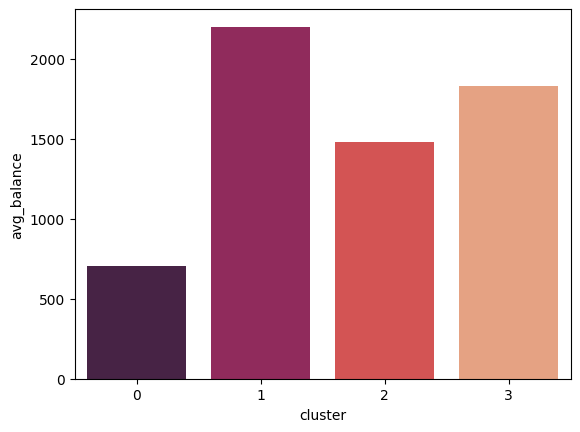

In [374]:
temp = pd.DataFrame({'cluster':['0','1','2','3'], 'avg_balance':[avg_c0,avg_c1,avg_c2,avg_c3]})
sns.barplot(x=temp['cluster'], y=temp['avg_balance'], palette=palette)

## Marital status VS. Balance

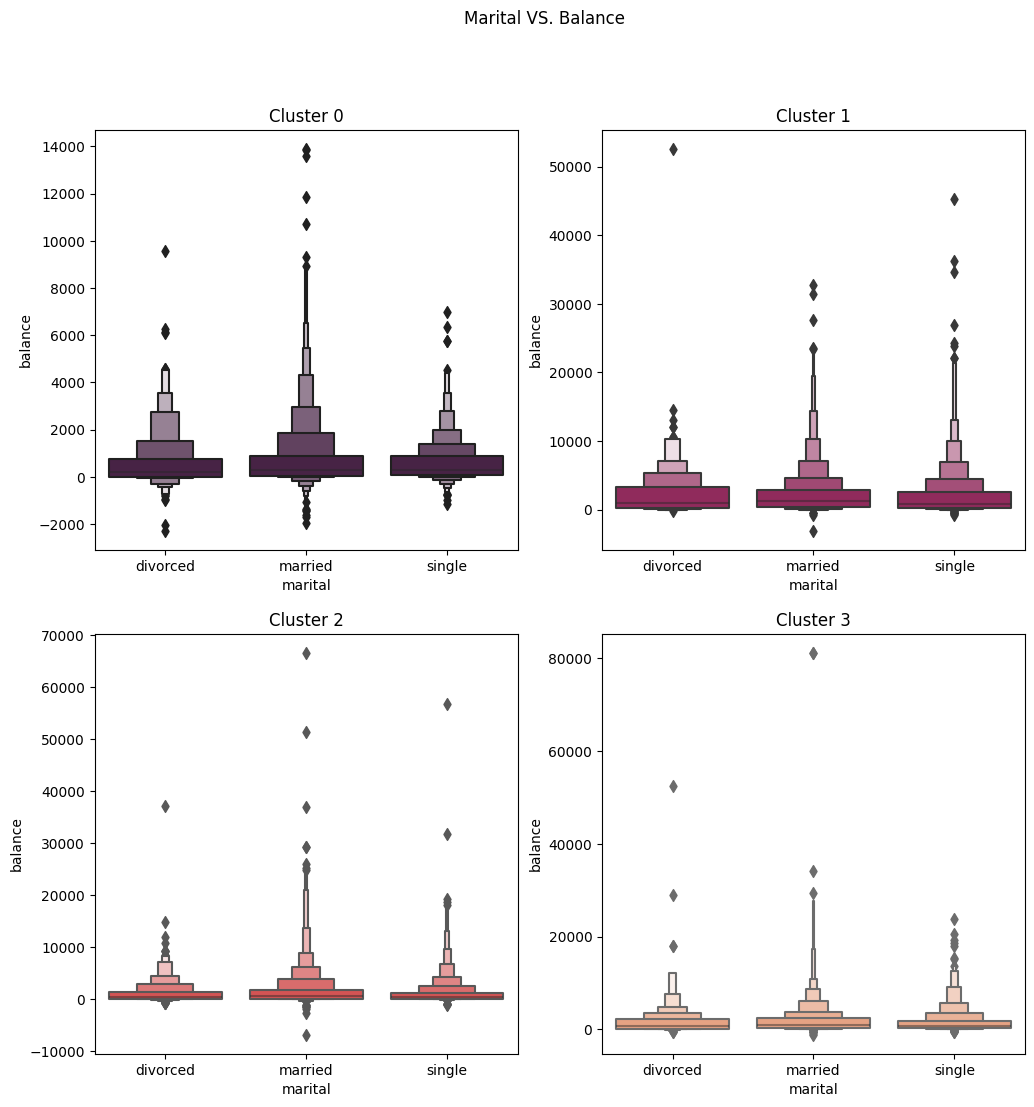

In [375]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(
    12, 12))

sns.boxenplot(ax=axs[0, 0], y=cluster0['balance'],
              x=cluster0['marital'], color=colors[0])
axs[0, 0].set_title('Cluster 0')

sns.boxenplot(ax=axs[0, 1], y=cluster1['balance'],
              x=cluster1['marital'], color=colors[1])
axs[0, 1].set_title('Cluster 1')

sns.boxenplot(ax=axs[1, 0], y=cluster2['balance'],
              x=cluster2['marital'], color=colors[2])
axs[1, 0].set_title('Cluster 2')

sns.boxenplot(ax=axs[1, 1], y=cluster3['balance'],
              x=cluster3['marital'], color=colors[3])
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Marital VS. Balance')
plt.savefig('./Plot/Evaluating/8-marital-vs-balance.png')
plt.show()


## Age group VS. Balance

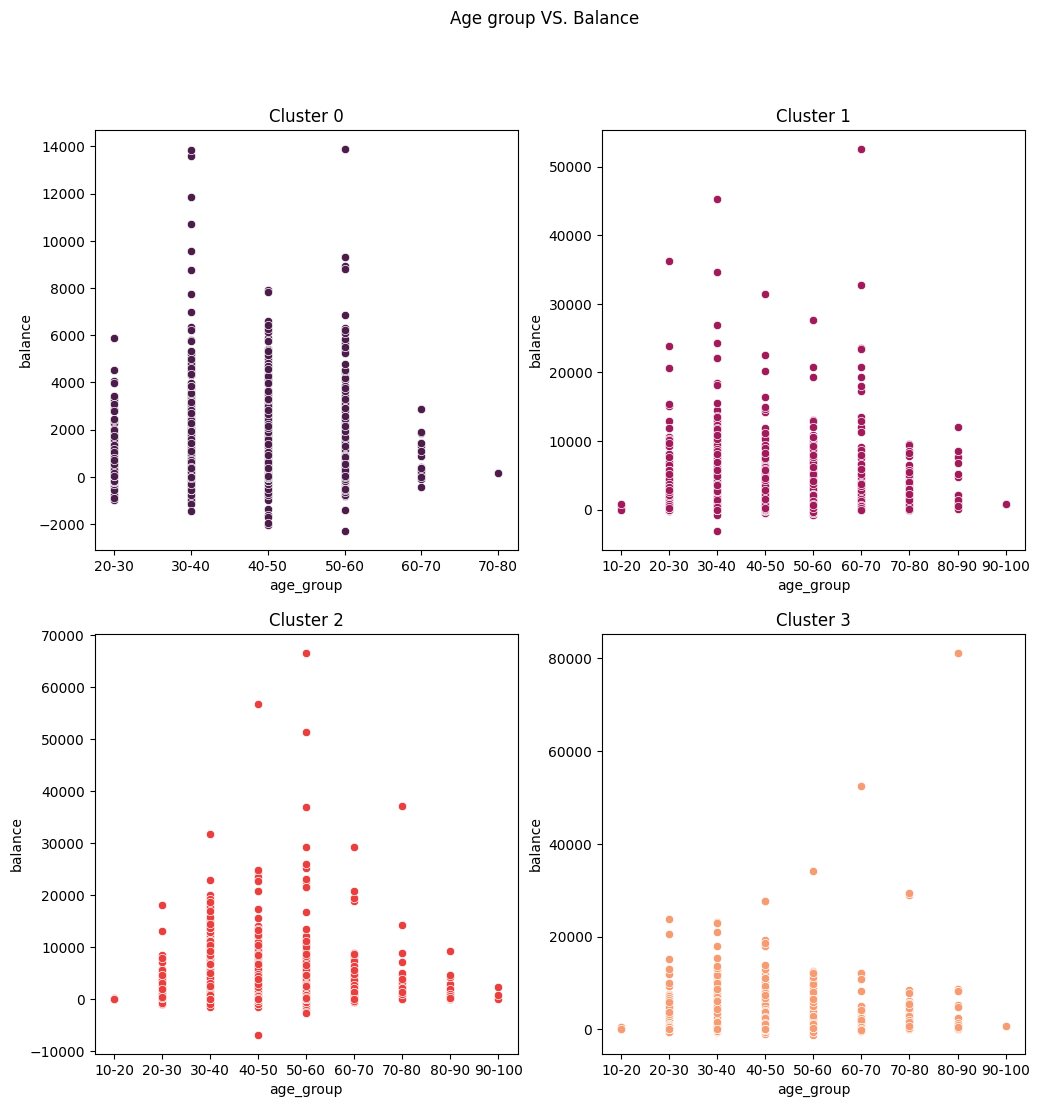

In [376]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(
    12, 12))

sns.scatterplot(ax=axs[0, 0], y=cluster0['balance'],
              x=cluster0['age_group'], color=colors[0])
axs[0, 0].set_title('Cluster 0')

sns.scatterplot(ax=axs[0, 1], y=cluster1['balance'],
              x=cluster1['age_group'], color=colors[1])
axs[0, 1].set_title('Cluster 1')

sns.scatterplot(ax=axs[1, 0], y=cluster2['balance'],
              x=cluster2['age_group'], color=colors[2])
axs[1, 0].set_title('Cluster 2')

sns.scatterplot(ax=axs[1, 1], y=cluster3['balance'],
              x=cluster3['age_group'], color=colors[3])
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Age group VS. Balance')
plt.savefig('./Plot/Evaluating/9-age-group-vs-balance.png')
plt.show()


## Campaign contacting VS. Outcome

Campaign contacting VS. Successful/Failed Outcome

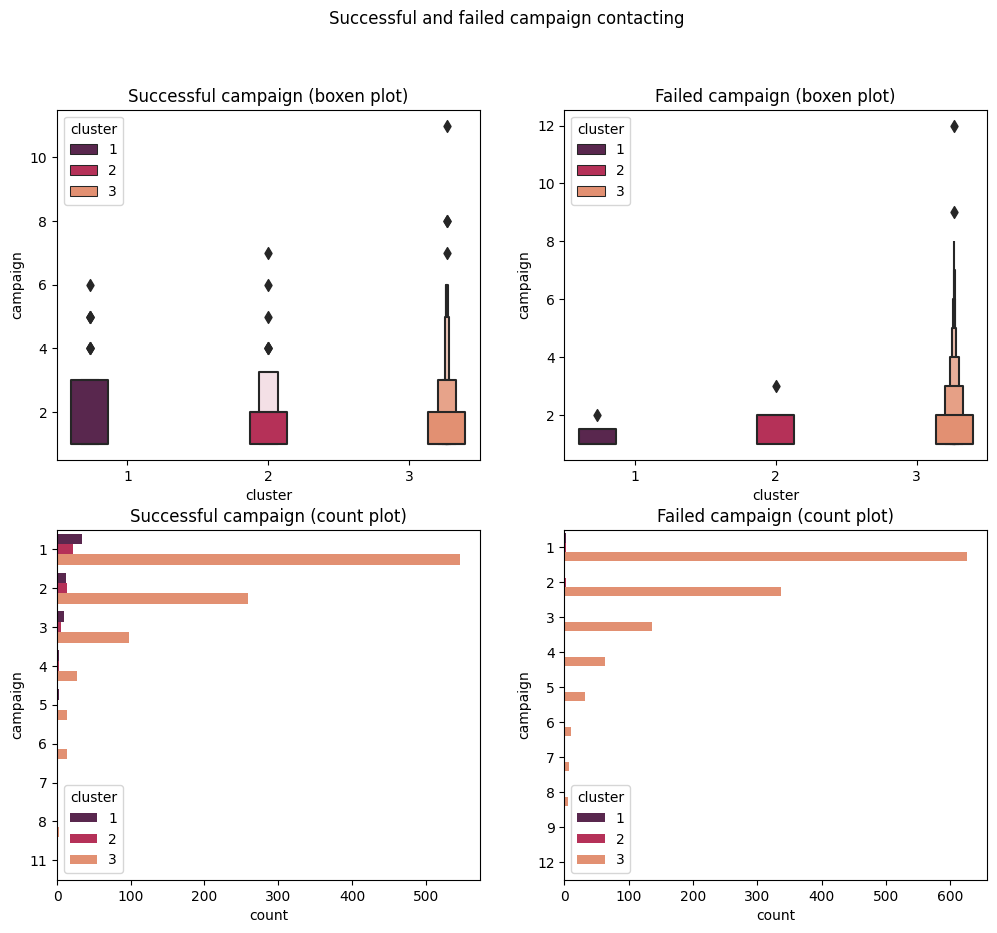

In [377]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10) )

temp = df[(df['poutcome']=='success')]
sns.boxenplot(ax=axs[0,0], y=temp['campaign'], x=temp['cluster'], palette=palette, hue=temp['cluster'])
axs[0,0].set_title('Successful campaign (boxen plot)')
sns.countplot(ax=axs[1,0], y=temp['campaign'],  palette=palette, hue=temp['cluster'])
axs[1,0].set_title('Successful campaign (count plot)')

temp = df[(df['poutcome']=='failure')]
sns.boxenplot(ax=axs[0,1], y=temp['campaign'], x=temp['cluster'], palette=palette, hue=temp['cluster'])
axs[0,1].set_title('Failed campaign (boxen plot)')
sns.countplot(ax=axs[1,1], y=temp['campaign'], palette=palette, hue=temp['cluster'])
axs[1,1].set_title('Failed campaign (count plot)')

plt.suptitle('Successful and failed campaign contacting')
plt.savefig('./Plot/Evaluating/10-success-n-fail-outcome-campaign.png')

plt.show()


Campaign contacting VS. Unknown Outcome

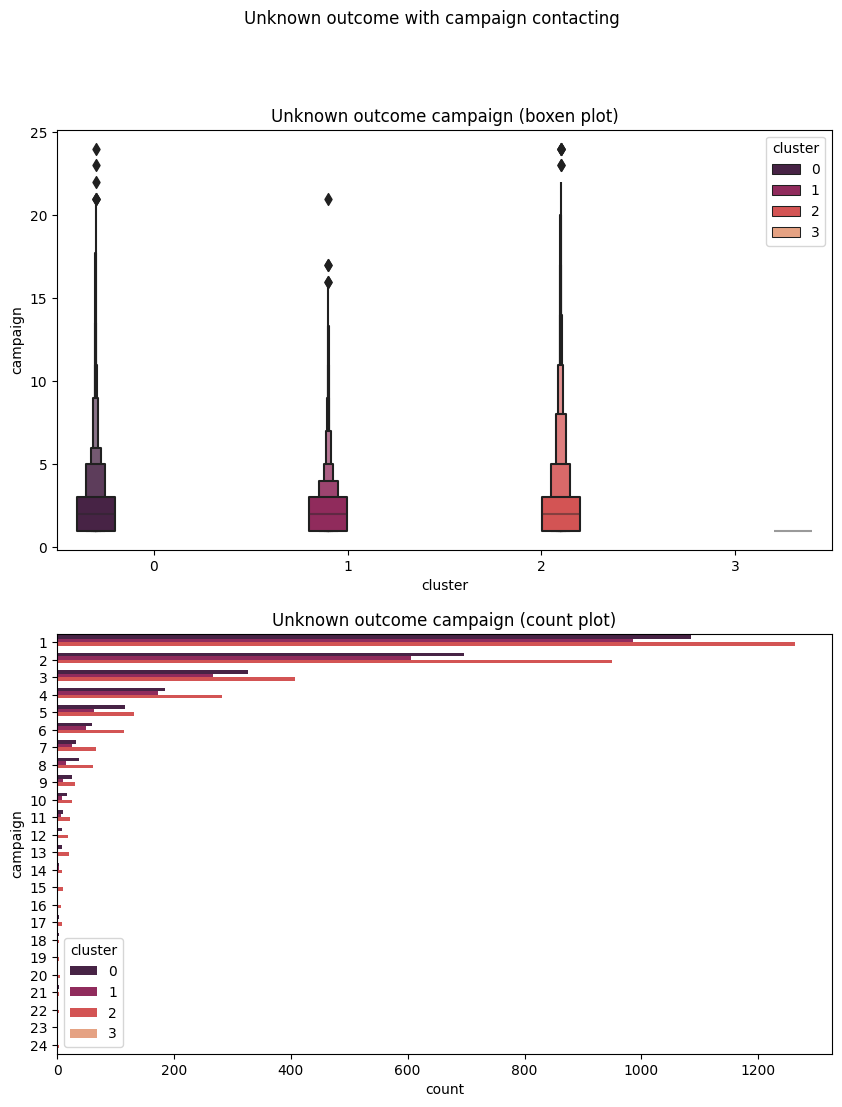

In [378]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,12))

temp = df[(df['poutcome']=='unknown') & (df['campaign'] < 25)]
sns.boxenplot(ax=axs[0], y=temp['campaign'], x=temp['cluster'], palette=palette, hue=temp['cluster'])
axs[0].set_title('Unknown outcome campaign (boxen plot)')
sns.countplot(ax=axs[1], y=temp['campaign'],  palette=palette, hue=temp['cluster'])
axs[1].set_title('Unknown outcome campaign (count plot)')

plt.suptitle('Unknown outcome with campaign contacting')
plt.savefig('./Plot/Evaluating/11-unknown-outcome-campaign.png')
plt.show()


## Deposit

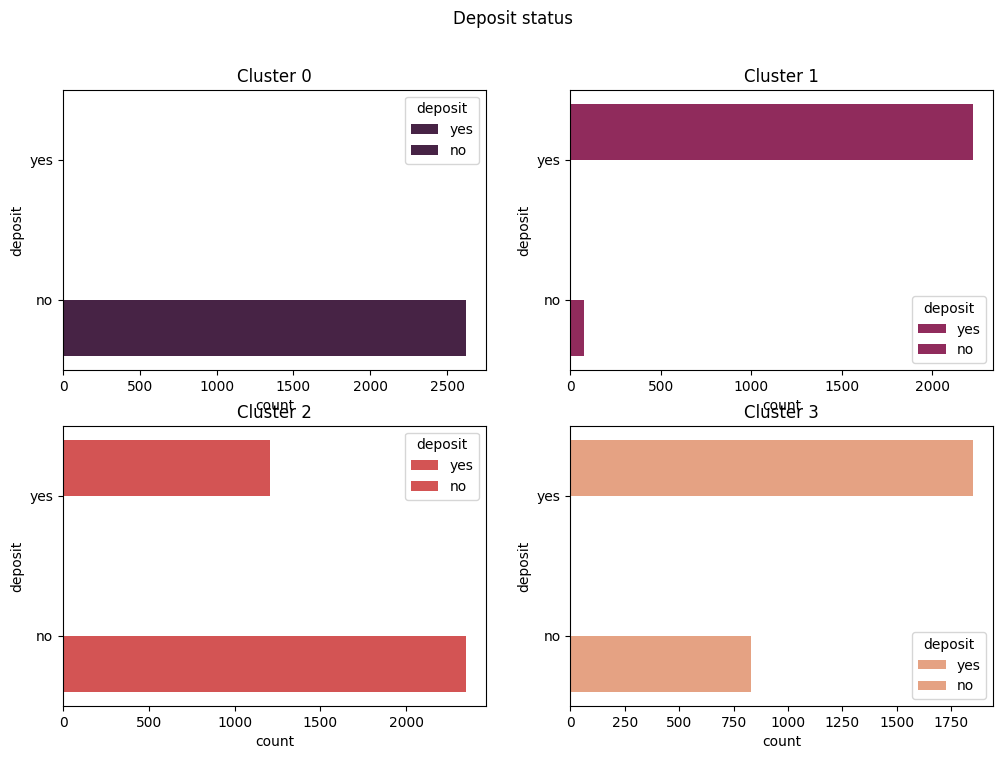

In [400]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
colors = sns.color_palette(palette, n_colors=4)

order = ['yes', 'no']

sns.countplot(ax=axs[0, 0], y=cluster0['deposit'],palette=[colors[0], colors[0]],hue=cluster0['deposit'])
axs[0,0].set_title('Cluster 0')

sns.countplot(ax=axs[0, 1], y=cluster1['deposit'],palette=[colors[1], colors[1]],hue=cluster1['deposit'])
axs[0, 1].set_title('Cluster 1')

sns.countplot(ax=axs[1, 0], y=cluster2['deposit'],palette=[colors[2], colors[2]],hue=cluster2['deposit'])
axs[1, 0].set_title('Cluster 2')

sns.countplot(ax=axs[1, 1], y=cluster3['deposit'],palette=[colors[3], colors[3]],hue=cluster3['deposit'])
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Deposit status')
plt.savefig('./Plot/Evaluating/12-deposit-status.png')
plt.show()


## Housing loan and personal loan

Housing loan

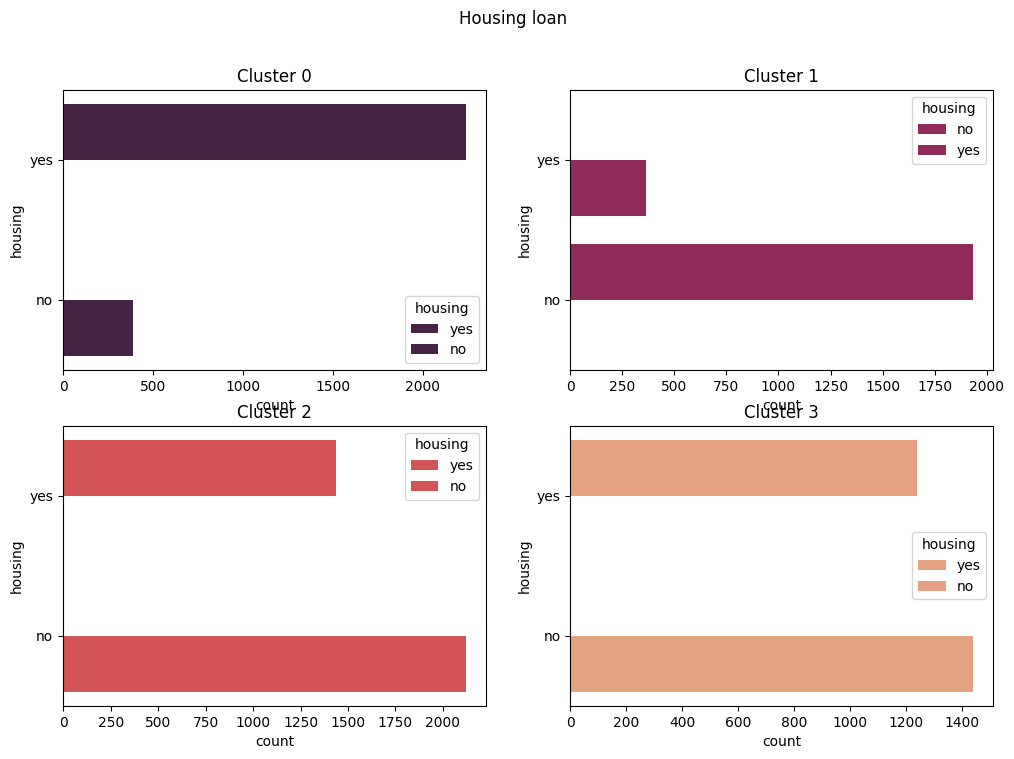

In [396]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

sns.countplot(ax=axs[0, 0], y=cluster0['housing'],
              hue=cluster0['housing'], palette=[colors[0], colors[0]])
axs[0, 0].set_title('Cluster 0')

sns.countplot(ax=axs[0, 1], y=cluster1['housing'],
              hue=cluster1['housing'], order=order, palette=[colors[1], colors[1]])
axs[0, 1].set_title('Cluster 1')

sns.countplot(ax=axs[1, 0], y=cluster2['housing'],
              hue=cluster2['housing'], palette=[colors[2], colors[2]])
axs[1, 0].set_title('Cluster 2')

sns.countplot(ax=axs[1, 1], y=cluster3['housing'],
              hue=cluster3['housing'], palette=[colors[3], colors[3]])
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Housing loan')
plt.savefig('./Plot/Evaluating/13-housing-loan.png')
plt.show()


Personal loan

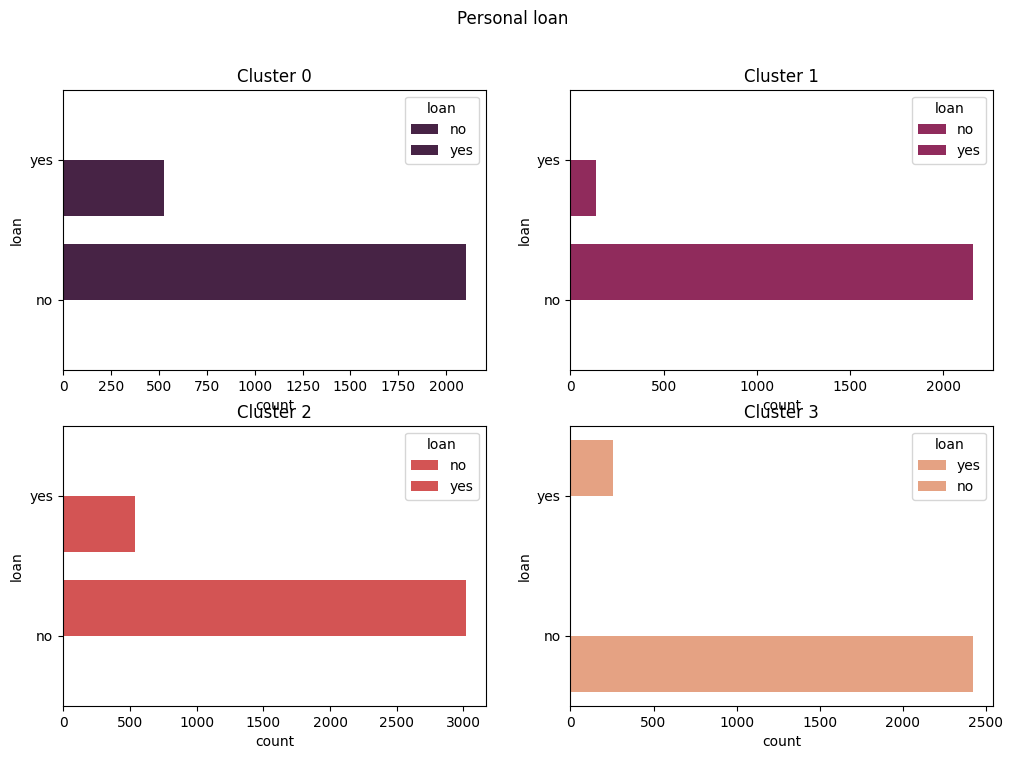

In [399]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(
    12, 8))

sns.countplot(ax=axs[0, 0], y=cluster0['loan'],
              palette=[colors[0], colors[0]], hue=cluster0['loan'], order=order)
axs[0, 0].set_title('Cluster 0')

sns.countplot(ax=axs[0, 1], y=cluster1['loan'],
              palette=[colors[1], colors[1]], hue=cluster1['loan'],order=order)
axs[0, 1].set_title('Cluster 1')

sns.countplot(ax=axs[1, 0], y=cluster2['loan'],
              palette=[colors[2], colors[2]], hue=cluster2['loan'],order=order)
axs[1, 0].set_title('Cluster 2')

sns.countplot(ax=axs[1, 1], y=cluster3['loan'],
              palette=[colors[3], colors[3]], hue=cluster3['loan'],order=order)
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Personal loan')
plt.savefig('./Plot/Evaluating/14-personal-loan.png')
plt.show()


Plotting where client has both housing and personal loan 

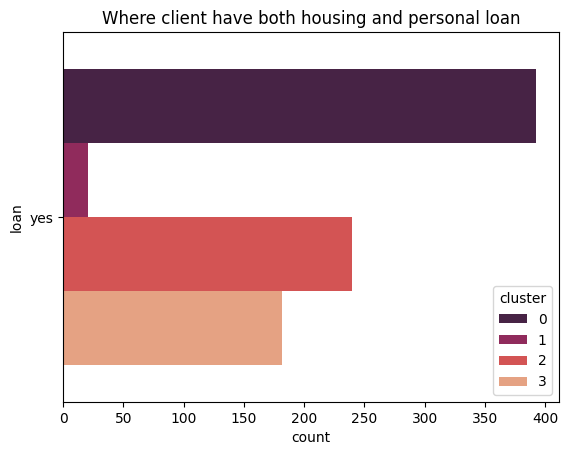

In [382]:
temp = df[(df['housing']=='yes') & (df['loan']=='yes')]
sns.countplot(y=temp['loan'], palette=palette, hue=temp['cluster'])

plt.title('Where client have both housing and personal loan')
plt.savefig('./Plot/Evaluating/15-both-loan.png')
plt.show()

## Default

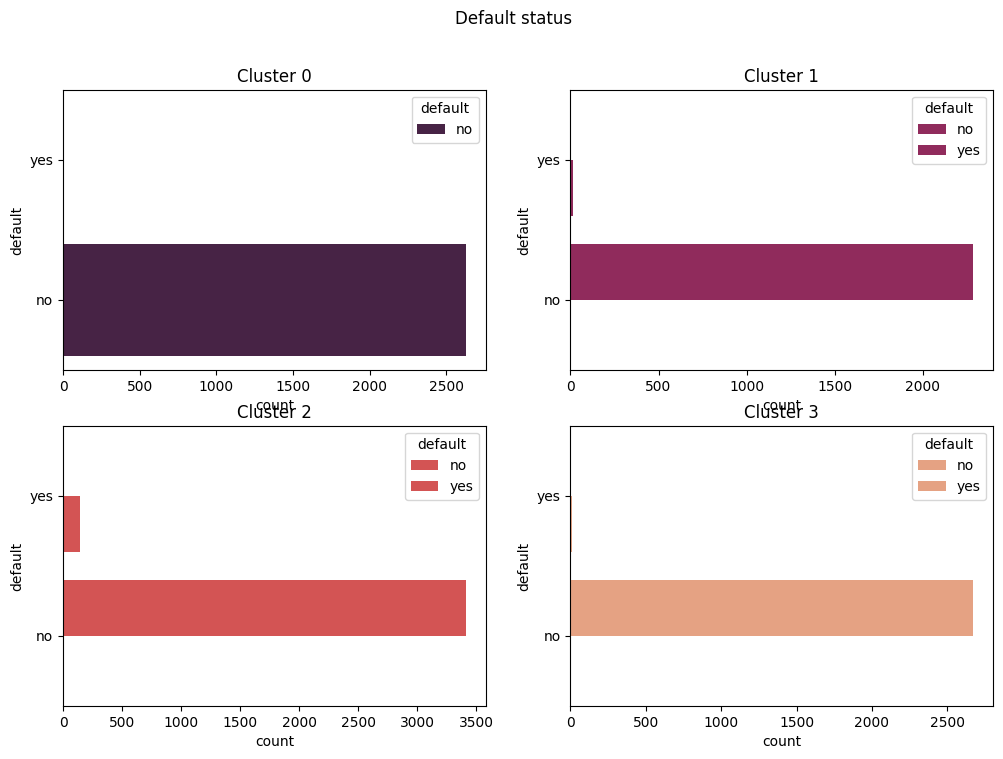

In [397]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
colors = sns.color_palette(palette, n_colors=4)

sns.countplot(ax=axs[0, 0], y=cluster0['default'],palette=[colors[0], colors[0]],hue=cluster0['default'], order=order)
axs[0,0].set_title('Cluster 0')

sns.countplot(ax=axs[0, 1], y=cluster1['default'],palette=[colors[1], colors[1]],hue=cluster1['default'], order=order)
axs[0, 1].set_title('Cluster 1')

sns.countplot(ax=axs[1, 0], y=cluster2['default'],palette=[colors[2], colors[2]],hue=cluster2['default'], order=order)
axs[1, 0].set_title('Cluster 2')

sns.countplot(ax=axs[1, 1], y=cluster3['default'],palette=[colors[3], colors[3]],hue=cluster3['default'], order=order)
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Default status')
plt.savefig('./Plot/Evaluating/16-Default-status.png')
plt.show()

## Job VS. Campaign Outcomes

With Success outcome

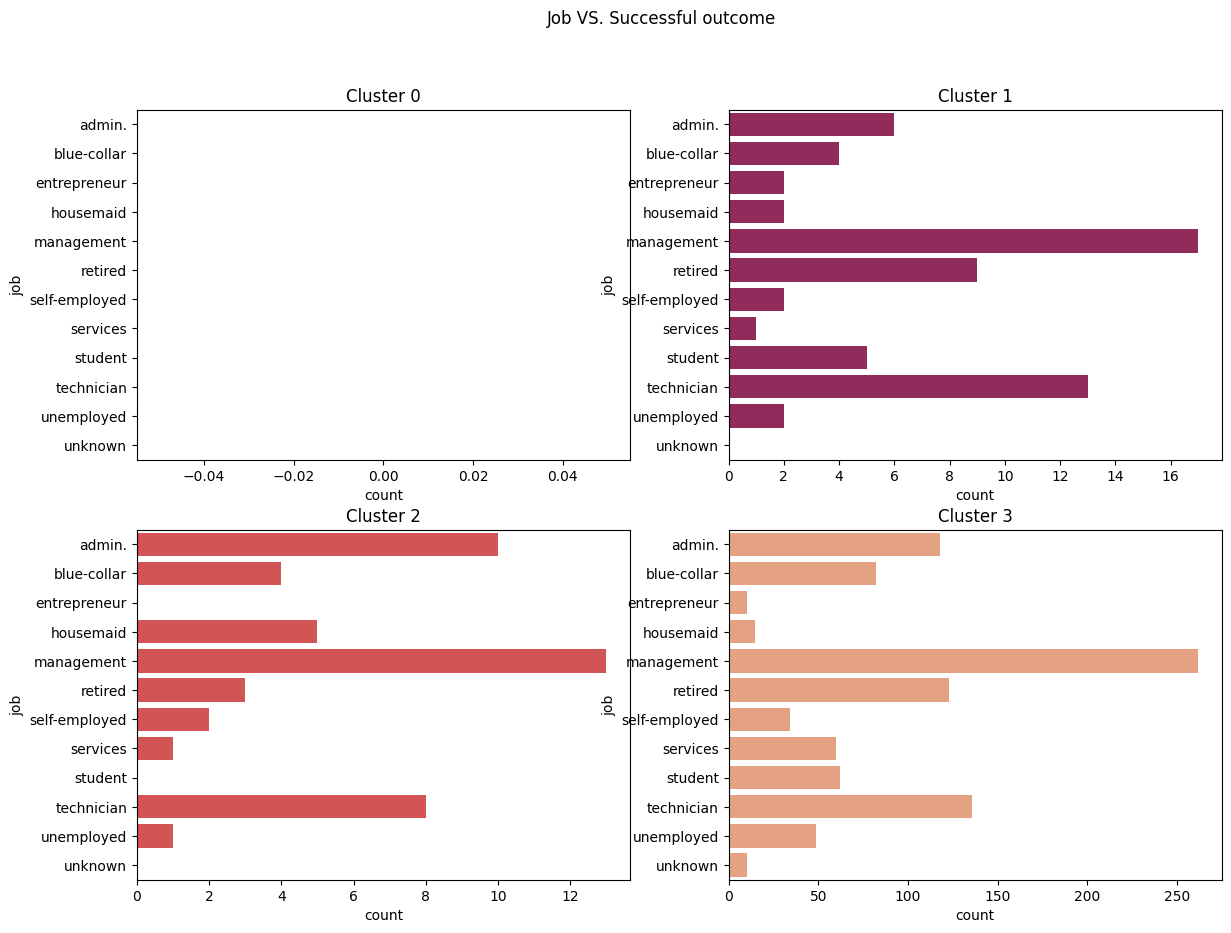

In [384]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
colors = sns.color_palette(palette, n_colors=4)

temp = cluster0[(cluster0['poutcome']=='success')]
sns.countplot(ax=axs[0, 0], y=temp['job'], color=colors[0])
axs[0,0].set_title('Cluster 0')

temp = cluster1[(cluster1['poutcome']=='success')]
sns.countplot(ax=axs[0, 1], y=temp['job'],color=colors[1])
axs[0, 1].set_title('Cluster 1')

temp = cluster2[(cluster2['poutcome']=='success')]
sns.countplot(ax=axs[1, 0], y=temp['job'],color=colors[2])
axs[1, 0].set_title('Cluster 2')

temp = cluster3[(cluster3['poutcome']=='success')]
sns.countplot(ax=axs[1, 1], y=temp['job'],color=colors[3])
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Job VS. Successful outcome')
plt.savefig('./Plot/Evaluating/17-job.png')
plt.show()

With Failure Outcome

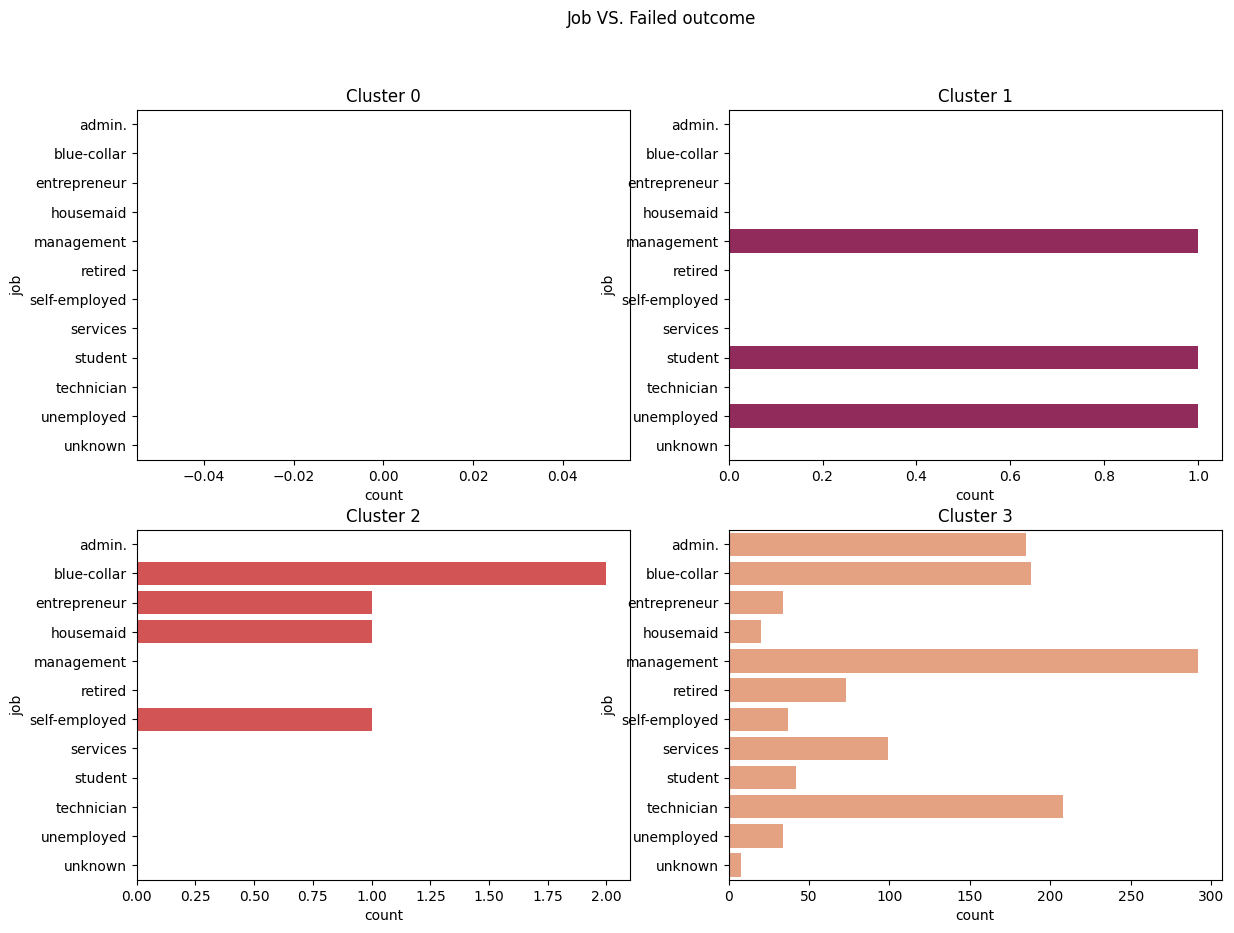

In [385]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
colors = sns.color_palette(palette, n_colors=4)

temp = cluster0[(cluster0['poutcome']=='failure')]
sns.countplot(ax=axs[0, 0], y=temp['job'], color=colors[0])
axs[0,0].set_title('Cluster 0')

temp = cluster1[(cluster1['poutcome']=='failure')]
sns.countplot(ax=axs[0, 1], y=temp['job'],color=colors[1])
axs[0, 1].set_title('Cluster 1')

temp = cluster2[(cluster2['poutcome']=='failure')]
sns.countplot(ax=axs[1, 0], y=temp['job'],color=colors[2])
axs[1, 0].set_title('Cluster 2')

temp = cluster3[(cluster3['poutcome']=='failure')]
sns.countplot(ax=axs[1, 1], y=temp['job'],color=colors[3])
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Job VS. Failed outcome')
plt.savefig('./Plot/Evaluating/18-job.png')
plt.show()

Unknown outcome

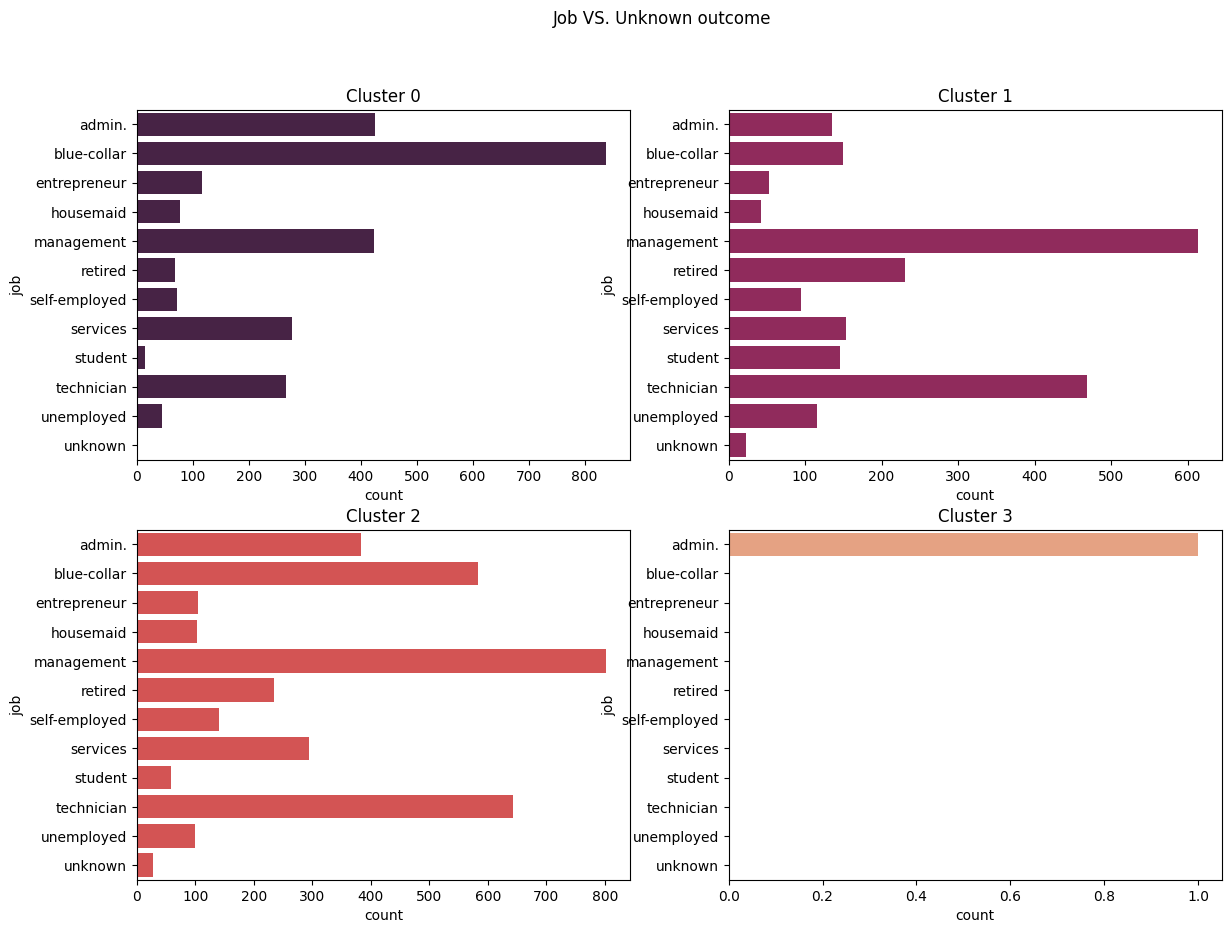

In [386]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
colors = sns.color_palette(palette, n_colors=4)

temp = cluster0[(cluster0['poutcome']=='unknown')]
sns.countplot(ax=axs[0, 0], y=temp['job'], color=colors[0])
axs[0,0].set_title('Cluster 0')

temp = cluster1[(cluster1['poutcome']=='unknown')]
sns.countplot(ax=axs[0, 1], y=temp['job'],color=colors[1])
axs[0, 1].set_title('Cluster 1')

temp = cluster2[(cluster2['poutcome']=='unknown')]
sns.countplot(ax=axs[1, 0], y=temp['job'],color=colors[2])
axs[1, 0].set_title('Cluster 2')

temp = cluster3[(cluster3['poutcome']=='unknown')]
sns.countplot(ax=axs[1, 1], y=temp['job'],color=colors[3])
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Job VS. Unknown outcome')
plt.savefig('./Plot/Evaluating/19-job.png')
plt.show()

## Education

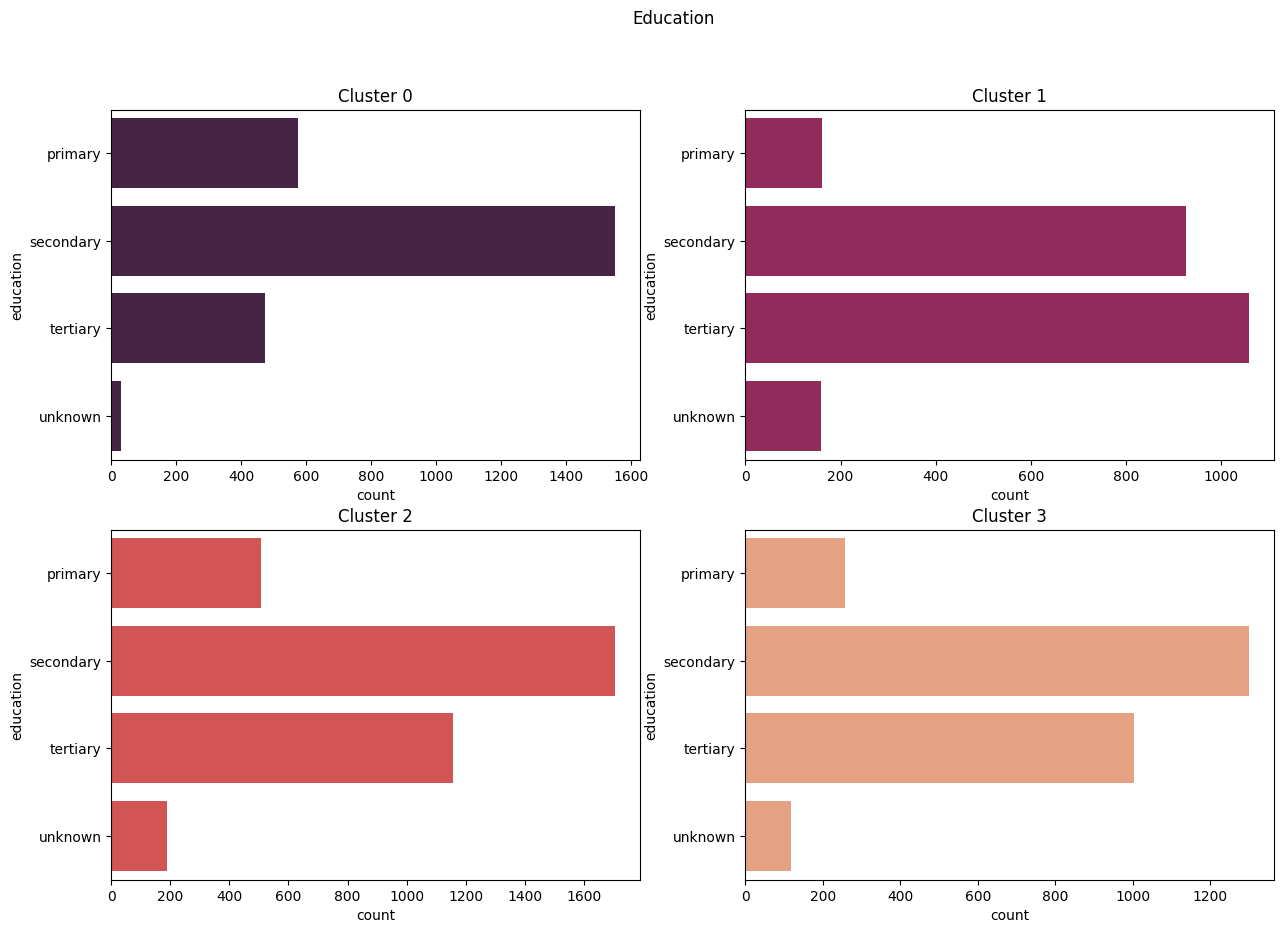

In [387]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
colors = sns.color_palette(palette, n_colors=4)

sns.countplot(ax=axs[0, 0], y=cluster0['education'], color=colors[0])
axs[0,0].set_title('Cluster 0')

sns.countplot(ax=axs[0, 1], y=cluster1['education'],color=colors[1])
axs[0, 1].set_title('Cluster 1')

sns.countplot(ax=axs[1, 0], y=cluster2['education'],color=colors[2])
axs[1, 0].set_title('Cluster 2')

sns.countplot(ax=axs[1, 1], y=cluster3['education'],color=colors[3])
axs[1, 1].set_title('Cluster 3')

plt.suptitle('Education')
plt.savefig('./Plot/Evaluating/20-education.png')
plt.show()

# Conclusion

Here are the special features of each cluster. Ranking 1-4 (highest to lowest) showing clients whom the bank should take care of or spend less time for. 

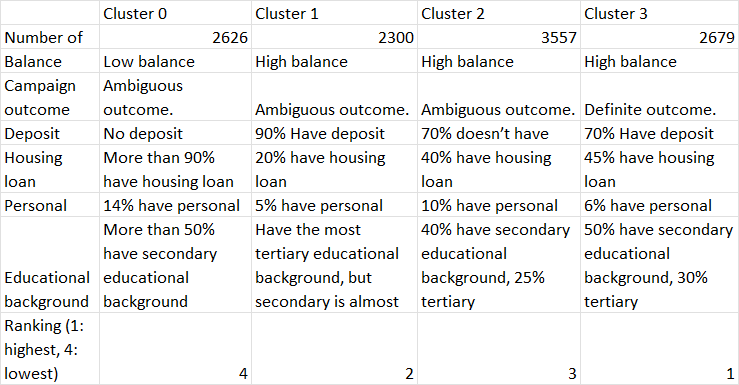